In [1]:
import math 
import os
import re
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from concurrent.futures import ThreadPoolExecutor
import logging
from os import listdir
from os.path import isfile, join
from random import sample
from scipy.spatial import distance
from scipy.cluster import hierarchy as hc
from scipy.linalg import sqrtm, block_diag, pinvh, eigh
from numpy.linalg import inv, pinv
from numpy.random import normal, poisson, randint
from numpy import diagflat, eye, fill_diagonal, diag, sqrt, min, max
from sklearn.utils import resample

from aux_functions import *
from utls import *
from read_connectomes import *

import mne
import numpy as np
from scipy.signal import hilbert
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt


# Experiments

In [2]:
#Read data
Ns = 109
runs = [6, 10, 14] # Motor imagery: left hand, right hand, both hands


population_graphs = []
for subject in range(1, Ns):
    A, G = read_adj_matrix_envelope(subject, runs)
    population_graphs.append(A)

#Create projected and inverted GLs
d = np.shape(A)[0]

population = [] 
U = GenONbasisVec(d) #ON basis for projection of GL
for p in population_graphs:
    population.append(genGLFast(p, U)) #compute and project GL

Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   

/Users/suvorikova/Desktop/git_boot/bw_paper/read_connectomes.py:80: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])
/Users/suvorikova/Desktop/git_boot/bw_paper/read_connectomes.py:80: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])
/Users/suvorikova/Desktop/git_boot/bw_paper/read_connectomes.py:80: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])


Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/suvorikova/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   

In [3]:
#remove GLs with rank<d-1

ind_to_keep = []
for i in range(len(population)):
    ev, evec = eigh(population[i])
    if (np.min(ev) > 0):
        ind_to_keep.append(i)

population = [population[i] for i in ind_to_keep]

In [4]:
# # Visualize the connectome graph
# pos = nx.spring_layout(G, seed=42)  # Layout for the graph
# plt.figure(figsize=(10, 10))
# nx.draw_networkx_nodes(G, pos, node_size=70)
# nx.draw_networkx_edges(G, pos, width=.2, alpha=0.6)
# nx.draw_networkx_labels(G, pos, font_size=2, font_family='sans-serif')
# plt.title(f'Connectome Graph (Subject {subject}, Envelope Correlation)')
# plt.show()

In [5]:
#Initiate resampling parameters
szs = [10, 50, 70] #sample sizes to compute the empirical barycenter
N = 1000 #number of points to construct a curve
M = 100  #number of bootstrap/asymptotic curves
d = np.shape(population[0])[0]
setting = 'real_'

In [6]:
boot_all = []
true_all = []

for n in szs:
    print(n)
    #true distribution
    dist_true = true_distr(population, size = n, boot_samples=N, setting = setting)
    true_all.append(dist_true)
    # #bootstrap
    stat_boot  = bootstrap(population, size = n, iters = M, boot_samples = N, model = "Poisson", setting = setting)
    boot_all.append(stat_boot)


# #asymptotic distribution
# stat_asymp = asymptotic_statistics(population, size = n, iters = M, boot_samples = N, setting=setting)

10
1 0.4162027036608745
2 0.0004946933385442826
Success! Iterations number: 2
50
1 0.4162027036608745
2 0.0004946933385442826
Success! Iterations number: 2
70
1 0.4162027036608745
2 0.0004946933385442826
Success! Iterations number: 2


In [10]:
ecdfs_boot_all = []
ecdfs_true_all = []
m_all = []
v_all = []
for j in range(len(szs)):
    dist_true = true_all[j]
    stat_boot = boot_all[j]
    
    x_grd = find_grid(dist_true, stat_boot, stat_boot, steps = 100)

    ecdfs_boot  = compute_ecdfs(stat_boot, x_grd)
    ecdfs_boot_all.append(ecdfs_boot )
    # ecdfs_asymp = compute_ecdfs(stat_asymp, x_grd)
    ecdf_true = ecdf_on_grid(dist_true, x_grd)
    ecdfs_true_all.append(ecdf_true)
    m_boot, v_boot = compute_KS_stat(ecdf_true, ecdfs_boot)
    m_all.append(m_boot)
    v_all.append(v_boot)
    # m_asmp, v_asmp = compute_KS_stat(ecdf_true, ecdfs_asymp)


    # print(m_boot, v_boot)
    # print(m_asmp, v_asmp) 

In [13]:
v_all

[0.031526347499999996, 0.013445973600000003, 0.0152328331]

In [8]:
# KS_var_asm = ceil_to_decimals(v_asmp , 3)
# KS_mean_asm = ceil_to_decimals(m_asmp, 3)
# KS_var_boot = ceil_to_decimals(v_boot, 3)  
# KS_mean_boot = ceil_to_decimals(m_boot, 3)  

# Plots

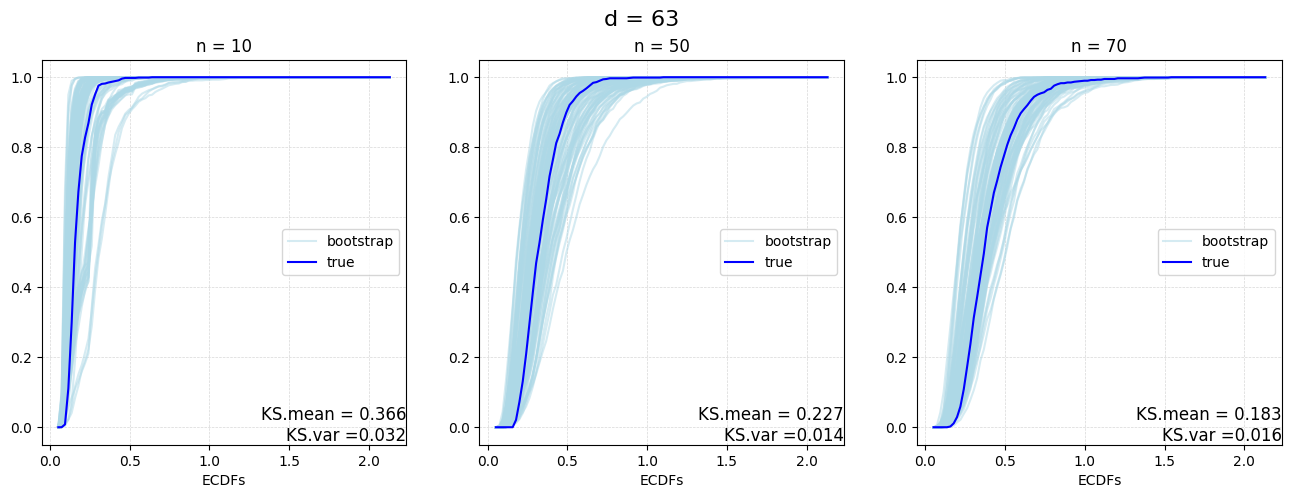

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for j in range(len(szs)):

    ecdfs_boot = ecdfs_boot_all[j]
    for i in range(len(ecdfs_boot)):  
        if (i == 1):
            axes[j].plot(x_grd, ecdfs_boot[i], c='lightblue', alpha = .5, label="bootstrap")
        else:
            axes[j].plot(x_grd, ecdfs_boot[i], c = 'lightblue', alpha = .5)
            

    ecdf_true = ecdfs_true_all[j]
    axes[j].plot(x_grd, ecdf_true, c = 'blue', label='true', lw = 1.5)

    axes[j].set_title("n = {0}".format(szs[j]))
    axes[j].set_xlabel("ECDFs")
    # axes[0].set_ylabel("sin(x)")
    axes[j].legend(loc='center right')
    axes[j].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid
    xlim1 = axes[j].get_xlim()
    ylim1 = axes[j].get_ylim()

    # Place text in the lower-right corner of the first plot
    mn = ceil_to_decimals(m_all[j], 3)
    vr = ceil_to_decimals(v_all[j], 3)
    axes[j].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(mn, vr), fontsize=12, color='black', 
                ha='right', va='bottom')


# for i in range(len(ecdfs_asymp)):  
#     if (i == len(ecdfs_asymp) - 1):
#         axes[1].plot(x_grd, ecdfs_asymp[i], c='orange', alpha = .5, label='asymp.')
#     else:
#         axes[1].plot(x_grd, ecdfs_asymp[i], c = 'orange', alpha = .5)

# axes[1].plot(x_grd, ecdf_true, c = 'blue', label='true', lw = 1.5)
# axes[1].set_title("Asymptotic")
# axes[1].set_xlabel("ECDFs")
# # axes[0].set_ylabel("sin(x)")
# axes[1].legend(loc='best')
# axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid

# # Place text in the lower-right corner of the first plot
# axes[1].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(KS_mean_asm, KS_var_asm), fontsize=12, color='black', 
#              ha='right', va='bottom')



fig.suptitle("d = {0}".format(d), fontsize=16)

plt.savefig(setting+"boot_cdfs_d={0}_n={1}_L_proj.png".format(d, n), dpi=300)